# <div style="text-align: center"> Robustness and fairness</div>
#### <div style="text-align: right"> Prof. Changho Suh, TA Jaewoong Cho, Gyeongjo Hwang</div>

# 1. Data poisoning and robust machine learning

**실습목표**
- Clean dataset과 Poisoned dataset을 인위적으로 생성한다. 
- 각각의 dataset에 logistic regression을 적용한 뒤 성능을 측정하고, poisoning 정도에 따라 성능 저하를 확인한다. 
- poisoning data에 robust한 Learn to Reweight 알고리즘을 구현한다.
- Poisoned dataset에 Learn to Reweight 기반 logistic regression을 적용한 뒤 성능을 측정하고, poisoning 정도에 따라 성능 저하를 확인한다. 

**목차**
- 로지스틱 회귀 및 딥러닝의 일반적인 구조에 대해 구현
 - 매개변수 (parameter) 초기화
 - 경사 (gradient) 계산
 - 최적화 알고리즘: 경사하강법 (Gradient Descent)
- 로지스틱 회귀를 Synthetic Data 및 실제 데이터에 적용

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from robust_utils import generate_normal, plot, Logistic_regression, draw_boundary, sigmoid
from tqdm import tqdm
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = (12, 8)

## 1-A. Clean dataset 및 Poisoned dataset 생성

**실습:**

- 두 가우시안 확률 분포로 부터 synthetic data 생성하고 plotting 하기 
- 주어진 데이터의 label을 flip 시켜서 poisoned data 생성하고 plotting. 

### 1. clean dataset을 생성하고 plotting하기

<img src="figures/hynix_figure1.png" style="width:800px;height:300px;" >

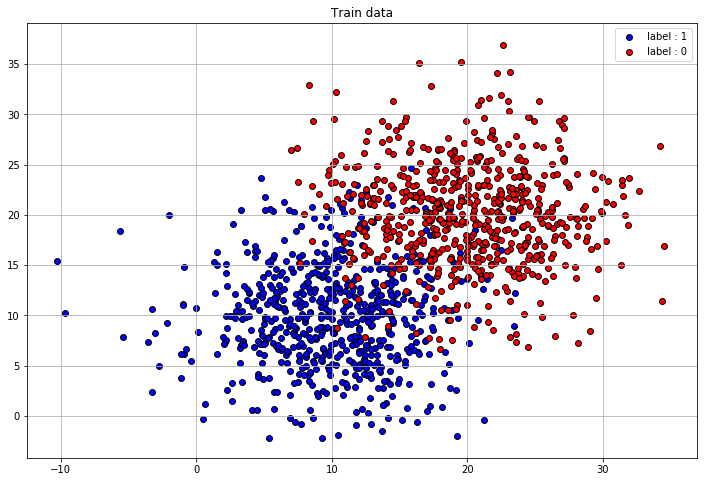

In [6]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.2)
plot(X_train, Y_train)

### 2. clean dataset과 숫자가 주어졌을 때 해당 갯수만큼 label을 flip하는 함수를 구현하시오.
<img src="figures/hynix_figure2.png" style="width:800px;height:300px;" >

In [19]:
def simple_poison(X, Y, poison_rate):
    '''
    Poison "n_of_poison" number of data points by flipping their labels 
    
    Returns:
    X_poison_train, Y_poison_train
    '''
    
    n_of_poison = int((X.shape[1]) * poison_rate)
    Y_copy = np.copy(Y)
    if n_of_poison !=0:
        Y_copy[-n_of_poison:] = 1 - Y_copy[-n_of_poison:]

    return X, Y_copy

def concat_train_val(X_train, Y_train, X_val, Y_val):
    return np.concatenate((X_val, X_train), axis=1), np.concatenate((Y_val, Y_train))

def Normalize(data):
    return (data - data.mean()) / data.std()

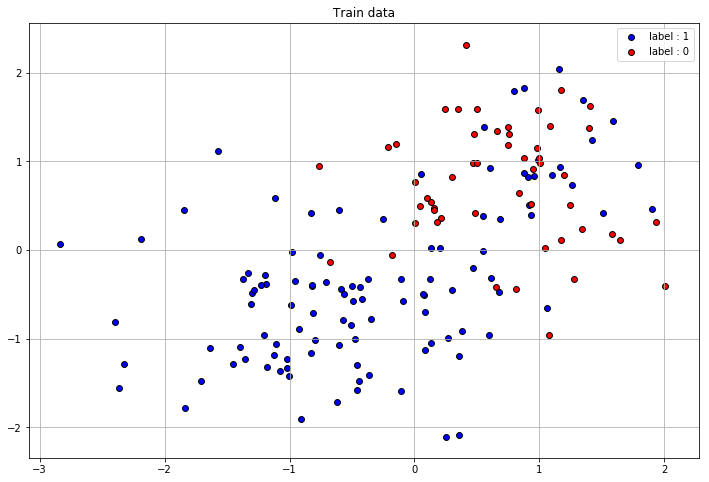

In [20]:
X_train, Y_train_poison = simple_poison(X_train, Y_train, 0.2)
X_train, Y_train_poison = concat_train_val(X_train, Y_train_poison, X_val, Y_val)
X_train = Normalize(X_train)
plot(X_train, Y_train_poison)

### 1-B. 데이터에 logistic regression을 적용하여 성능 측정하기 

**실습:**

- Poison rate을 아래와 같이 변화시키며 logistic regression 성능 측정하기

100%|██████████| 5000/5000 [00:00<00:00, 18554.47it/s]


train accuracy: 93.57142857142857 %
test accuracy: 94.0 %


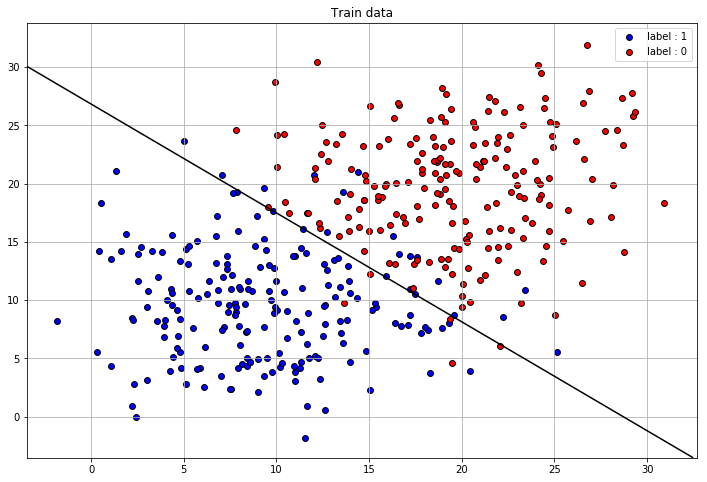

In [27]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.125)
(X_train, Y_train), (X_val, Y_val), (_, _) = generate_normal(n_samples=200, val_portion=0.125)
d = Logistic_regression(X_train, Y_train, X_test, Y_test, learning_rate=0.01, num_iterations=5000)
draw_boundary(d['w'], d['b'], X_test, Y_test)

In [119]:
poison_rate = np.linspace(0, 1, 11)
accuracies = []
for pr in poison_rate:
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.125)
    (X_train, Y_train), (X_val, Y_val), (_, _) = generate_normal(n_samples=200, val_portion=0.125)
    X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
    X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
    d = Logistic_regression(X_train, Y_train_poison, X_test, Y_test, learning_rate=0.01, num_iterations=20000)
    accuracies.append(d['test_acc'])
    print(d['w'], d['b'])

 19%|█▊        | 3731/20000 [00:00<00:00, 18871.58it/s]

train accuracy: 92.14285714285714 %
test accuracy: 94.25 %
[[-2.60224421]
 [-2.77747963]] -0.12225753472011501


 19%|█▉        | 3794/20000 [00:00<00:00, 19004.97it/s]

train accuracy: 82.14285714285714 %
test accuracy: 87.75 %
[[-1.2192981]
 [-1.1364319]] 0.7610870998875582


 18%|█▊        | 3678/20000 [00:00<00:00, 18516.50it/s]

train accuracy: 69.28571428571428 %
test accuracy: 74.25 %
[[-0.66222158]
 [-1.00106083]] 1.2251861406764248


  9%|▉         | 1830/20000 [00:00<00:00, 18293.30it/s]

train accuracy: 77.14285714285714 %
test accuracy: 57.25 %
[[-0.4026545 ]
 [-0.94539498]] 1.7794560513799689


 19%|█▊        | 3717/20000 [00:00<00:00, 18671.61it/s]

train accuracy: 88.57142857142857 %
test accuracy: 51.5 %
[[ 0.2633345 ]
 [-1.60036136]] 2.92257892581797


 19%|█▉        | 3819/20000 [00:00<00:00, 19106.79it/s]

train accuracy: 100.0 %
test accuracy: 50.0 %
[[ 0.11351455]
 [-0.11517822]] 5.315619566808971


 18%|█▊        | 3651/20000 [00:00<00:00, 18212.22it/s]

train accuracy: 90.0 %
test accuracy: 50.0 %
[[0.68831561]
 [0.12291358]] 2.427782679169903


 18%|█▊        | 3639/20000 [00:00<00:00, 18203.05it/s]

train accuracy: 78.57142857142857 %
test accuracy: 47.5 %
[[0.83334591]
 [0.2272462 ]] 1.6523583165053997


 18%|█▊        | 3698/20000 [00:00<00:00, 18464.22it/s]

train accuracy: 71.42857142857143 %
test accuracy: 24.0 %
[[0.99186825]
 [0.55086176]] 1.1751664938039363


 19%|█▉        | 3824/20000 [00:00<00:00, 19176.10it/s]

train accuracy: 82.85714285714286 %
test accuracy: 11.0 %
[[1.01949544]
 [1.33248931]] 0.7670703407122836


100%|██████████| 20000/20000 [00:01<00:00, 18943.24it/s]

train accuracy: 92.14285714285714 %
test accuracy: 5.75 %
[[2.61150425]
 [2.78383081]] 0.123184122669192


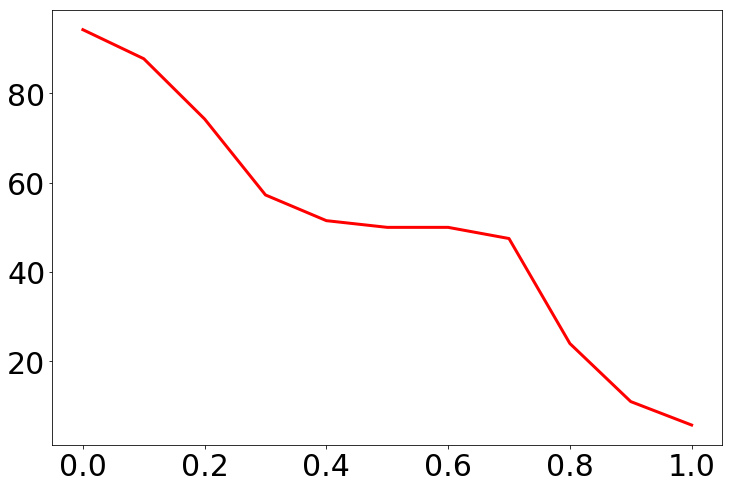

In [151]:
# plt.scatter(poison_rate, accuracies, color='r')


plt.plot(poison_rate, accuracies, 'r-', linewidth=3)
axes = plt.gca()
axes.tick_params(axis="x", labelsize=30)
axes.tick_params(axis="y", labelsize=30)
# plt.grid(True)
# plt.xlabel('% of poison', fontsize=14)
# plt.ylabel('test accuracy', fontsize=14)

### 1-C. Learn to reweight 알고리즘 구현

In [38]:
def initialize_weights(dim, n_train):
    np.random.seed(0)
    
    w = np.random.randn(dim, 1)
    b = np.random.randn(1).item()
    mu = np.random.randn(n_train, 1)

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    assert(mu.shape == (n_train, 1))
    
    return w, b, mu 

def forward(w, b, X, Y):
    
    Yhat = sigmoid(np.dot(w.T, X) + b)
    
    return Yhat

# def forward(w, b, X_train, Y_train, X_val, Y_val):
    
#     Yhat_t = sigmoid(np.dot(w.T, X_train) + b)
#     Yhat_v = sigmoid(np.dot(w.T, X_val) + b)
    
#     return Yhat_t, Yhat_v

def backward_mu(w, b, X_train, Y_train, X_val, Y_val, Yhat_t, Yhat_v, alpha):
    
    dmu = - alpha * (Yhat_t - Y_train).T * X_train.T@X_val@(Yhat_v - Y_val).T
    return dmu

def backward_params(w, b, mu, X, Y, Yhat):

    dw = np.dot(X, mu * ((Yhat - Y).T))
    db = np.dot((Yhat - Y), mu)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw,
                  "db": db}
    
    return grads

def fit(w, b, mu, X_train, Y_train, X_val, Y_val, num_iterations, alpha, beta, print_cost=False):
    
    costs = []
    batch_size = X_val.shape[1]
    
    for i in tqdm(range(num_iterations)):
        Yhat_t = forward(w, b, X_train, Y_train)
        grads = backward_params(w, b, mu, X_train, Y_train, Yhat_t)

        dw = grads["dw"]
        db = grads["db"]

        w = w - alpha * dw  
        b = b - alpha * db
        
        Yhat_v = forward(w, b, X_val, Y_val)
        
        dmu = backward_eps(w, b, X_train, Y_train, X_val, Y_val, Yhat_t, Yhat_v, alpha)
        mu = mu - beta*dmu
        mu = np.maximum(0, mu)
        if np.sum(mu) != 0:
            mu = mu / np.sum(mu)
    
    params = {"w": w,
                     "b": b,
                     "mu":mu}
    
    grads = {"dw": dw,
                  "db": db,
                  "dmu": dmu}
    
    return params, grads, costs


def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    ### START CODE HERE ### (≈ 4 line of code)
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

# GRADED FUNCTION: model

def robust_train(X_train, Y_train, X_val, Y_val, X_test, Y_test, num_iterations=2000, alpha=0.5, beta=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
#     w, b = initialize_weights(X_train.shape[0])
    w, b, mu = initialize_weights(X_train.shape[0], X_train.shape[1])
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = fit(w, b, mu, X_train, Y_train, X_val, Y_val, num_iterations, alpha, beta, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    mu = parameters["mu"]
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    print("train accuracy: {} %".format(train_acc))
    print("test accuracy: {} %".format(test_acc))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "num_iterations": num_iterations,
         "train_acc":train_acc,
         "test_acc":test_acc,
         "mu": mu,}
    
    return d

In [122]:
model_history = []
poison_rate = np.linspace(0, 1, 11)
accuracies_l2w = []

val_portion = 0.125

for pr in poison_rate:
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.1)
    (X_train, Y_train), (X_val, Y_val), (_, _) = generate_normal(n_samples=200, val_portion=val_portion)
    X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
#     X_train, Y_train_poison = concat_train_val(X_train, Y_train_poison, X_val, Y_val)
    X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
    d = robust_train(X_train, Y_train_poison, X_val, Y_val, X_test, Y_test, alpha=0.001, beta=0.001, num_iterations=20000)
    accuracies_l2w.append(d['test_acc'])
    model_history.append(d)
#     print(d['w'], d['b'])
#     print(d["grads"]["mu"])
temp.append(accuracies_l2w)

  8%|▊         | 1674/20000 [00:00<00:01, 16734.79it/s]

train accuracy: 92.14285714285714 %
test accuracy: 93.75 %


  8%|▊         | 1619/20000 [00:00<00:01, 16184.11it/s]

train accuracy: 83.57142857142857 %
test accuracy: 93.75 %


  8%|▊         | 1547/20000 [00:00<00:01, 15465.77it/s]

train accuracy: 77.85714285714286 %
test accuracy: 93.5 %


  8%|▊         | 1652/20000 [00:00<00:01, 16516.04it/s]

train accuracy: 71.42857142857143 %
test accuracy: 92.75 %


  8%|▊         | 1609/20000 [00:00<00:01, 16082.88it/s]

train accuracy: 66.42857142857143 %
test accuracy: 89.75 %


  8%|▊         | 1632/20000 [00:00<00:01, 16313.79it/s]

train accuracy: 100.0 %
test accuracy: 50.25 %


  8%|▊         | 1589/20000 [00:00<00:01, 15888.01it/s]

train accuracy: 60.0 %
test accuracy: 75.75 %


  8%|▊         | 1630/20000 [00:00<00:01, 16298.97it/s]

train accuracy: 50.0 %
test accuracy: 79.5 %


  8%|▊         | 1647/20000 [00:00<00:01, 16469.15it/s]

train accuracy: 38.57142857142857 %
test accuracy: 80.75 %


  8%|▊         | 1634/20000 [00:00<00:01, 16333.67it/s]

train accuracy: 26.428571428571416 %
test accuracy: 83.75 %


100%|██████████| 20000/20000 [00:01<00:00, 16347.04it/s]

train accuracy: 7.857142857142861 %
test accuracy: 92.25 %


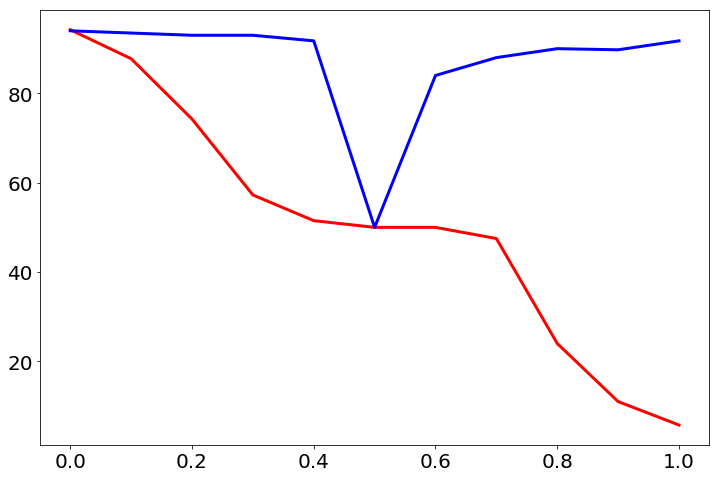

In [147]:
plt.plot(poison_rate, accuracies, 'r-', label = 'logistic regression', linewidth=3)
plt.plot(poison_rate, accuracies_l2w,'b-', label = 'learning to reweight', linewidth=3)
axes = plt.gca()
axes.tick_params(axis="x", labelsize=20)
axes.tick_params(axis="y", labelsize=20)
# plt.scatter(poison_rate, accuracies, color='r', label = 'logistic regression')
# plt.scatter(poison_rate, accuracies_l2w, color='b', label = 'learning to reweight')
# plt.xlabel('% of poison', fontsize=20)
# plt.ylabel('test accuracy', fontsize=20)
# plt.legend()

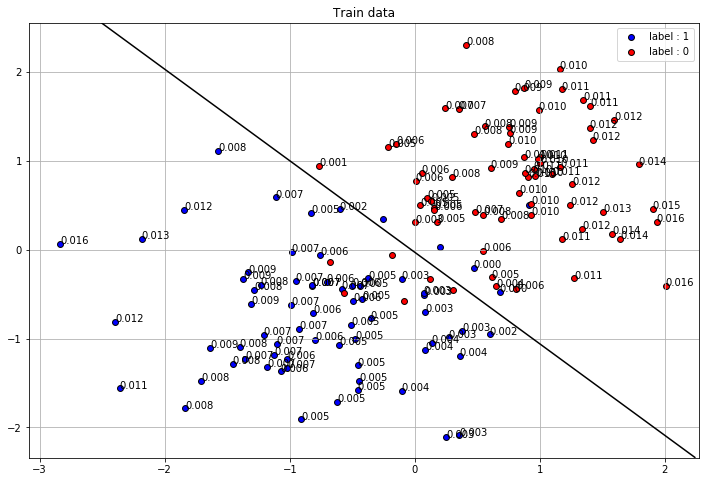

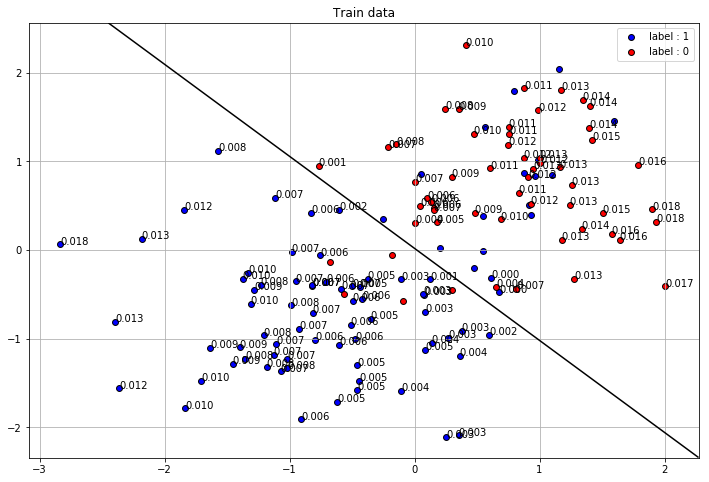

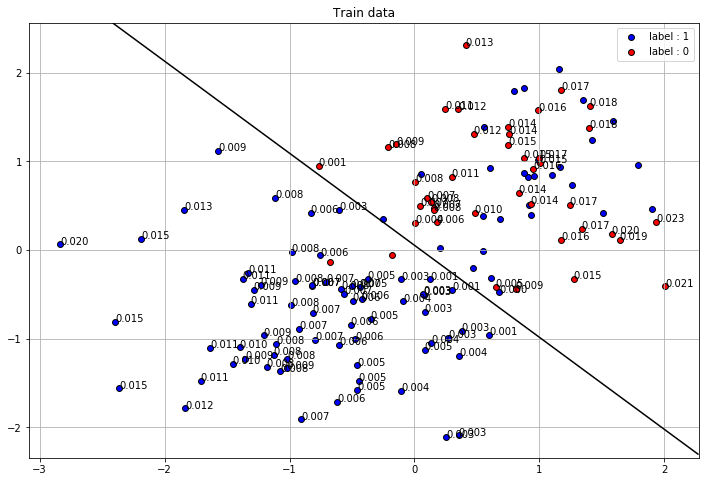

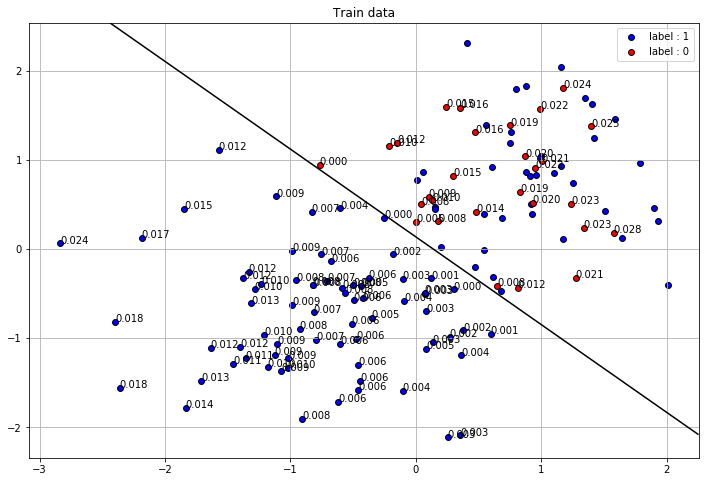

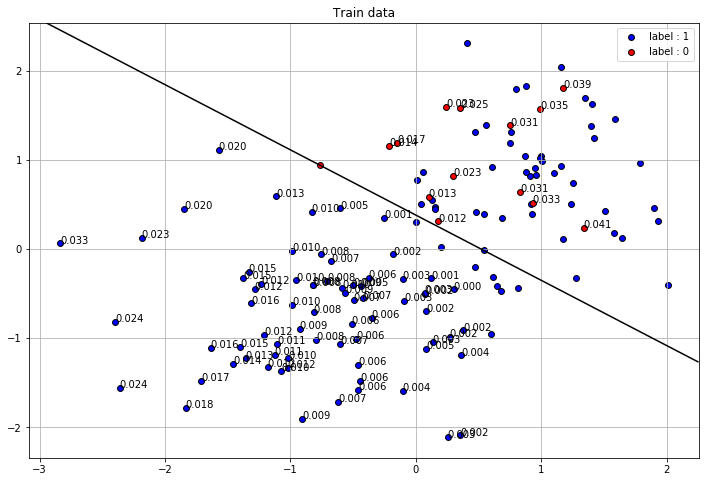

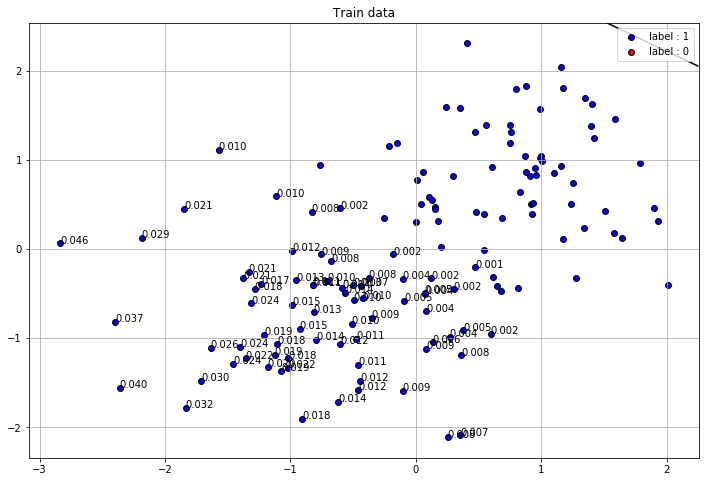

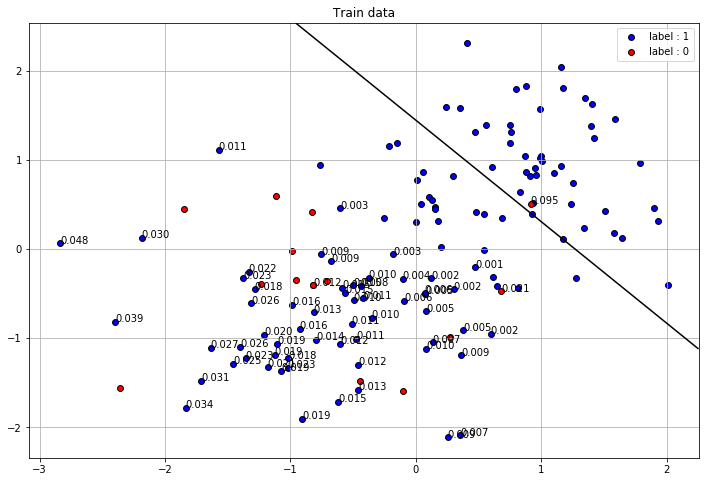

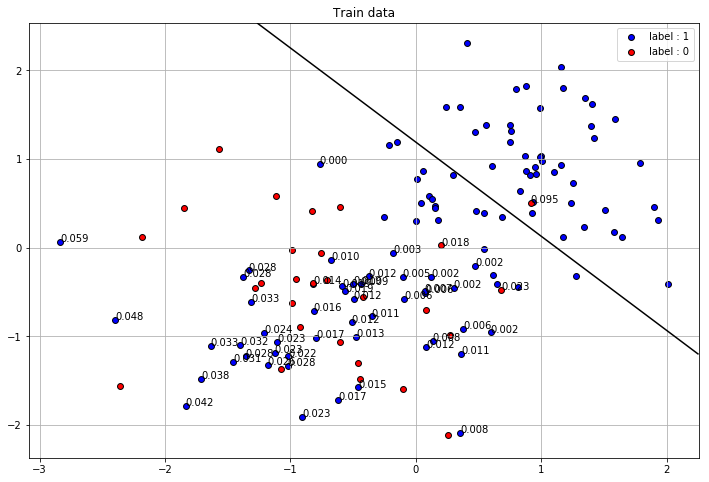

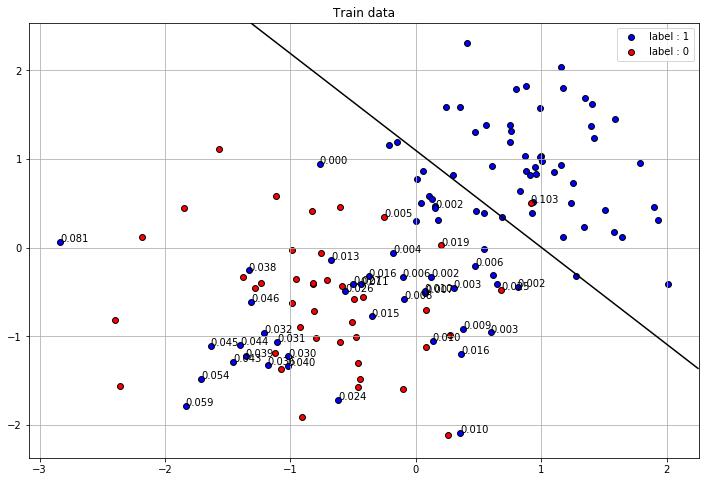

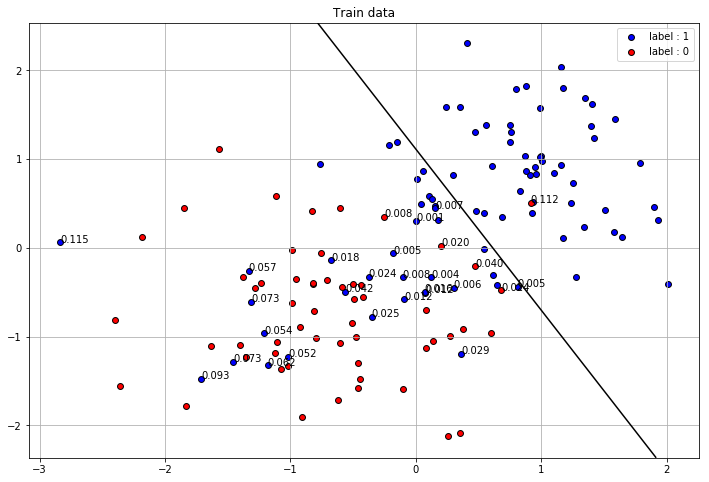

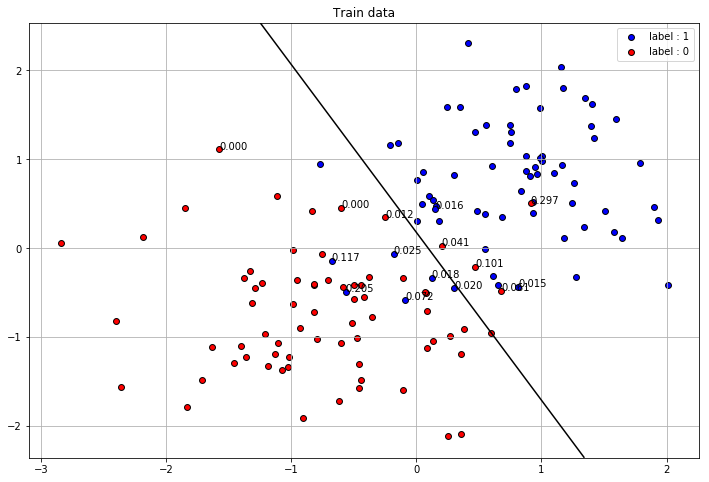

In [129]:
val_portion = 0.125

for i, pr in enumerate(poison_rate):
    # (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.002)
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.1)
    (X_train, Y_train), (X_val, Y_val), (_, _) = generate_normal(n_samples=200, val_portion=val_portion)
    X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
    X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
    
    d = model_history[i]
#     print(d['w'])
#     print(d['b'])
#     print()
    draw_boundary(d['w'], d['b'], X_train, Y_train_poison)
    
    ax = plt.gca()
    x = X_train[0, :]
    y = X_train[1, :]
    for i, xy in enumerate(zip(x, y)):
        if d["mu"][i] > 0:
            ax.annotate("{:.3f}".format(float(d["mu"][i])), xy=xy, textcoords="data")
    plt.show()

In [137]:
temp = []

vp_list = [0.125, 0.06125, 0.030625]

for val_portion in vp_list: 
    model_history = []
    poison_rate = np.linspace(0, 1, 11)
    accuracies_l2w = []
    for pr in poison_rate:
        (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = generate_normal(n_samples=2000, val_portion=0.1,seed = 2019)
        (X_train, Y_train), (X_val, Y_val), (_, _) = generate_normal(n_samples=200, val_portion=val_portion, seed=2019)
        X_train, Y_train_poison = simple_poison(X_train, Y_train, pr)
        X_train, X_val, X_test = Normalize(X_train), Normalize(X_val), Normalize(X_test)
        d = robust_train(X_train, Y_train_poison, X_val, Y_val, X_test, Y_test, alpha=0.001, beta=0.001, num_iterations=100000)
        accuracies_l2w.append(d['test_acc'])
        model_history.append(d)
    temp.append(accuracies_l2w)

  2%|▏         | 1637/100000 [00:00<00:06, 16368.06it/s]

train accuracy: 92.14285714285714 %
test accuracy: 92.75 %


  2%|▏         | 1639/100000 [00:00<00:06, 16384.00it/s]

train accuracy: 83.57142857142857 %
test accuracy: 92.75 %


  2%|▏         | 1672/100000 [00:00<00:05, 16714.72it/s]

train accuracy: 77.85714285714286 %
test accuracy: 92.5 %


  2%|▏         | 1506/100000 [00:00<00:06, 15053.73it/s]

train accuracy: 70.71428571428571 %
test accuracy: 92.75 %


  2%|▏         | 1680/100000 [00:00<00:05, 16795.17it/s]

train accuracy: 60.714285714285715 %
test accuracy: 92.25 %


  2%|▏         | 1647/100000 [00:00<00:05, 16469.31it/s]

train accuracy: 99.28571428571429 %
test accuracy: 53.5 %


  2%|▏         | 1609/100000 [00:00<00:06, 16084.45it/s]

train accuracy: 47.14285714285714 %
test accuracy: 91.0 %


  2%|▏         | 1636/100000 [00:00<00:06, 16352.80it/s]

train accuracy: 35.0 %
test accuracy: 92.5 %


  2%|▏         | 1642/100000 [00:00<00:05, 16417.04it/s]

train accuracy: 26.428571428571416 %
test accuracy: 92.75 %


  2%|▏         | 1643/100000 [00:00<00:05, 16423.01it/s]

train accuracy: 19.285714285714278 %
test accuracy: 94.0 %


  2%|▏         | 1710/100000 [00:00<00:05, 17090.64it/s]

train accuracy: 9.285714285714292 %
test accuracy: 93.75 %


  2%|▏         | 1694/100000 [00:00<00:05, 16939.25it/s]

train accuracy: 92.76315789473684 %
test accuracy: 92.0 %


  2%|▏         | 1793/100000 [00:00<00:05, 17926.73it/s]

train accuracy: 83.55263157894737 %
test accuracy: 92.0 %


  2%|▏         | 1716/100000 [00:00<00:05, 17159.93it/s]

train accuracy: 77.63157894736842 %
test accuracy: 91.5 %


  2%|▏         | 1741/100000 [00:00<00:05, 17409.31it/s]

train accuracy: 69.07894736842105 %
test accuracy: 91.25 %


  2%|▏         | 1670/100000 [00:00<00:05, 16693.21it/s]

train accuracy: 63.81578947368421 %
test accuracy: 88.5 %


  2%|▏         | 1693/100000 [00:00<00:05, 16925.17it/s]

train accuracy: 100.0 %
test accuracy: 50.25 %


  2%|▏         | 1722/100000 [00:00<00:05, 17215.42it/s]

train accuracy: 51.973684210526315 %
test accuracy: 86.5 %


  2%|▏         | 1750/100000 [00:00<00:05, 17497.18it/s]

train accuracy: 42.10526315789473 %
test accuracy: 87.5 %


  2%|▏         | 1771/100000 [00:00<00:05, 17704.70it/s]

train accuracy: 30.26315789473685 %
test accuracy: 88.25 %


  2%|▏         | 1722/100000 [00:00<00:05, 17216.32it/s]

train accuracy: 24.342105263157904 %
test accuracy: 84.5 %


  2%|▏         | 1678/100000 [00:00<00:05, 16777.98it/s]

train accuracy: 9.868421052631575 %
test accuracy: 88.75 %


  2%|▏         | 1778/100000 [00:00<00:05, 17777.86it/s]

train accuracy: 92.3076923076923 %
test accuracy: 94.0 %


  2%|▏         | 1700/100000 [00:00<00:05, 16992.64it/s]

train accuracy: 83.97435897435898 %
test accuracy: 93.5 %


  2%|▏         | 1687/100000 [00:00<00:05, 16869.94it/s]

train accuracy: 78.84615384615384 %
test accuracy: 93.0 %


  2%|▏         | 1670/100000 [00:00<00:05, 16694.64it/s]

train accuracy: 70.51282051282051 %
test accuracy: 93.0 %


  2%|▏         | 1821/100000 [00:00<00:05, 18206.11it/s]

train accuracy: 64.74358974358975 %
test accuracy: 91.75 %


  2%|▏         | 1745/100000 [00:00<00:05, 17440.62it/s]

train accuracy: 100.0 %
test accuracy: 50.0 %


  2%|▏         | 1719/100000 [00:00<00:05, 17187.23it/s]

train accuracy: 53.205128205128204 %
test accuracy: 84.0 %


  2%|▏         | 1567/100000 [00:00<00:06, 15663.82it/s]

train accuracy: 42.307692307692314 %
test accuracy: 88.0 %


  2%|▏         | 1539/100000 [00:00<00:06, 15381.80it/s]

train accuracy: 28.84615384615384 %
test accuracy: 90.0 %


  2%|▏         | 1801/100000 [00:00<00:05, 18005.25it/s]

train accuracy: 18.58974358974359 %
test accuracy: 89.75 %


100%|██████████| 100000/100000 [00:05<00:00, 17348.49it/s]

train accuracy: 7.692307692307693 %
test accuracy: 91.75 %


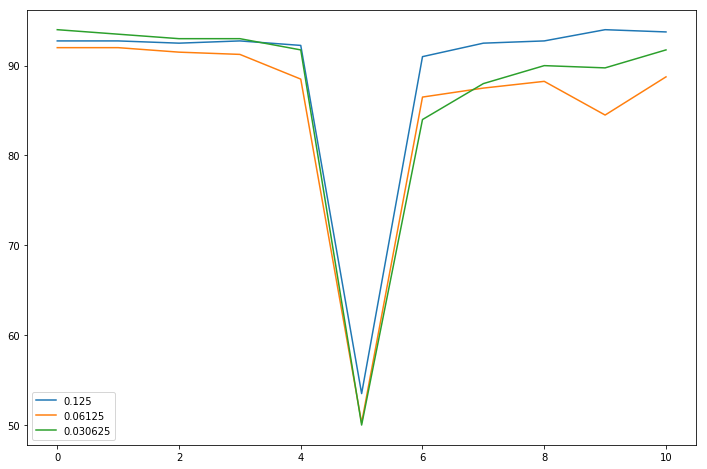

In [138]:
p_val = ["0.125","0.06125","0.030625"]
for i, j in enumerate(p_val):
    plt.plot(temp[i], label=j)


plt.legend()
plt.show()